# Определение эмоциональной окраски твитов с помощью BERT. Ужатая версия BERT

Попробуем воспроизвести примерно то же, что и на семинаре, но с использованием **уменьшенной версии модели BERT** (ориг. [Маленький и быстрый BERT для русского языка](https://habr.com/ru/post/562064/))

    "В качестве основы для модели я взял классический bert-multilingual (веса), ибо хочу, чтобы модель понимала и русский, и английский, и его же использую на ранних стадиях дистилляции как учителя по распределению токенов. Словарь этой модели содержит 120К токенов, но я отобрал только те, которые часто встречаются в русском и английском языках, оставив 30К. Размер эмбеддинга я сократил с 768 до 312, число слоёв – с 12 до 3. Эмбеддинги я инициализировал из bert-multilingual, все остальные веса – случайным образом."

И с учетом [туториала](https://huggingface.co/docs/transformers/training) (Fine-tune a pretrained model in native PyTorch)
- вообще изменения минимальные, все и так подошло

## Установка библиотек

Понадобится `transformers`, `sentencepiece`

In [1]:
# !pip install transformers sentencepiece

QUICK_RUN = True

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import get_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-04-21 12:16:35.520406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64
2022-04-21 12:16:35.520443: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


- Таблица параметров модели. Типа подробный `get_parameters()` 
- Все тензоры ноутбука
- Очистить память от ненужных тензоров/моделей

In [3]:
from helpers.summary import count_parameters, dump_tensors, free_mem

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 760


## Загрузка данных


In [5]:
import pandas as pd

pos_texts = pd.read_csv('datasets/bert_sentiment_analysis/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('datasets/bert_sentiment_analysis/negative.csv', encoding='utf8', sep=';', header=None)

In [6]:
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
81869,410760809166688256,1386767983,zmeevolk,@kakabadze сейчас сумму лимита стоимости 1000 ...,1,0,0,0,2696,60,77,0
50977,410042527689895936,1386596731,Shusharina96,Как я давно не ходила по магазинам. Скоро буде...,1,0,0,0,3974,85,57,0
19686,409406838992814080,1386445171,_Noisy_Killjoy_,"""гспд,он же вылитый Крейг :)"" Фото ridiculousg...",1,0,1,0,35140,1111,719,13
83272,410773983877791744,1386771124,Tor83V,@fantomrocker нетт конечно ) уважение надо зас...,1,0,0,0,58308,16740,12294,1507
86216,410802675115388928,1386777964,PashaSnowbell,"чувствую,что зачеты я буду сдавать так же) htt...",1,0,0,0,1022,43,29,0


In [7]:
pos_texts[3].apply(lambda x: len(x)).describe()[["mean", "std", "min", "max"]].round()

mean     85.0
std      27.0
min      21.0
max     179.0
Name: 3, dtype: float64

## Подготовка датасета


In [9]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])
labels = np.array([[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])])

In [10]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [11]:
print(sentences[1000])

Дим, ты помогаешь мне, я тебе, все взаимно, все правильно)


In [12]:
N = 1000
if QUICK_RUN:
    idx = np.random.choice(np.arange(len(sentences)), size = N)
    sentences = sentences[idx]
    labels = labels[idx]

Тренировочная и тестовая выборки

In [13]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(list(sentences), labels, test_size=0.3)
train_sentences, val_sentences, train_gt, val_gt = train_test_split(train_sentences, train_gt, test_size=0.1)

In [14]:
print(len(train_gt), len(test_gt))

630 300


In [15]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

In [16]:
train_encodings = tokenizer(train_sentences, truncation=True, padding=True)
val_encodings = tokenizer(val_sentences, truncation=True, padding=True)
test_encodings = tokenizer(test_sentences, truncation=True, padding=True)

В PyTorch принято оборачивать обучающие данные в класс. Он является наследником класса Dataset и переопределяет метод __len__ числа примеров и метод __getitem__ получения примера по индексу idx

Создав датасет, его можно передать объекту DataLoader, который будет выдавать батчи, перемешивать, разбивать на обучение и тест, нормализовать данные и т.п.

In [17]:
class RuTwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
train_dataset = RuTwitterDataset(train_encodings, train_gt)
val_dataset = RuTwitterDataset(val_encodings, val_gt)
test_dataset = RuTwitterDataset(test_encodings, test_gt)    

In [19]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(test_dataset, batch_size=32)

### Модель

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny", num_labels=2)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [21]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [22]:
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps
)

In [23]:
model.to(device)
count_parameters(model)

+--------------------------------------------------------+-----+-------------+------------+---------------+----------+
|                    Modules/Tensors                     | GPU |    Shape    | Parameters |      Type     | DataMem  |
+--------------------------------------------------------+-----+-------------+------------+---------------+----------+
|         bert.embeddings.word_embeddings.weight         |  +  | 29564 x 312 |  9223968   | torch.float32 | 36895872 |
|       bert.embeddings.position_embeddings.weight       |  +  |  512 x 312  |   159744   | torch.float32 |  638976  |
|      bert.embeddings.token_type_embeddings.weight      |  +  |   2 x 312   |    624     | torch.float32 |   2496   |
|            bert.embeddings.LayerNorm.weight            |  +  |     312     |    312     | torch.float32 |   1248   |
|             bert.embeddings.LayerNorm.bias             |  +  |     312     |    312     | torch.float32 |   1248   |
|    bert.encoder.layer.0.attention.self.query.w

11784794

## Обучение модели

Авторы статьи про BERT советуют выбирать: 
- learning rate из следующего списка: $5 \cdot 10^{-5}, 3 \cdot 10^{-5}, 2 \cdot 10^{-5}$, 
- количество эпох дообучения: 2, 3, 4.
- размер батча: 16, 32

### Оптимизатор с "регуляризацией"

`AdamW` - это реализация `Adam` с применением **Weight Decay**. 

Что такое Weight Decay? При каждом обновлении веса давайте кроме движения в сторону антиградиента еще и будем вычитать маленький кусочек веса, умноженный на некоторый гиперпараметр. Например, формула стохастического градиентного спуска с применением Weight Decay будет выглядеть так:

$w = w - lr * \dfrac{\partial L}{\partial w} - lr * wd * w$ 

Здесь lr - learning rate, wd - weight decay, гиперпараметр.

Если Вы внимательно посмотрите на эту формулу, то заметите, что в случае стохастического градиентного спуска Weight Decay эквивалентен применению L2-регуляризации к loss-функции:

$$L_{new} = L + \dfrac{wd}{2} ||w||^2 \\
 
\dfrac{\partial (L_{new})}{\partial w} = \dfrac{\partial L}{\partial w} + wd \cdot w \\

w = w - lr \cdot \dfrac{\partial L_{new}}{\partial w} = w - lr * \dfrac{\partial L}{\partial w} - lr * wd * w $$

Однако, L2-регуляризация (**меняем loss-функцию**) и Weight Decay (**не меняем loss-функцию**, меняем только способ обновления весов) работают одинаково только в простом случае стохастического градиентного спуска, в случае адаптивных оптимизаторов, например, Адама, эти два подхода различаются (причем эмпирически было показано, что часто Weight Decay работает лучше). Вся эта история породила некоторую путаницу в терминилогии, и во многих библиотеках Адам реализовали именно с применением L2-регуляризации, ошибочно называя такой подход Weight Decay.  Авторы статьи [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101) решили разграничить Adam+L2 и Adam+Weight Decay, назвав последнее AdamW.

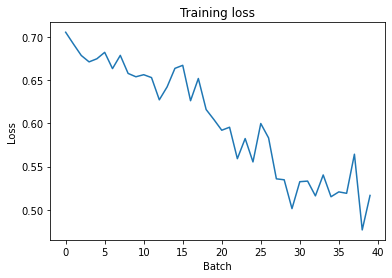

100%|██████████| 40/40 [00:11<00:00,  3.65it/s]

In [24]:
from IPython.display import clear_output

progress_bar = tqdm(range(num_training_steps))
loss_set = []

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loss_set.append(loss.detach().cpu())  
        # Рисуем график
        clear_output(True)
        plt.plot(loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
        # break
        progress_bar.update(1)

### Цикл обучения

На самом деле это 1 итерация цикла (1 эпоха), если надо, можно еще раз тыкнуть ичейку.

- переводим модель в train mode, 
- распаковываем входные данные (вектор с индексами токенов и метки классов)
- помещаем наши данные на GPU с помощью 
- не забываем очистить градиенты с прошлого шага с помощью `zero_grad()` 
- делаем forward pass, считаем loss, затем делаем backward pass, считаем градиенты, 
- дальше — стандартно — делаем optimizer.step(). 
 
Кроме того, в процессе обучения мы будем рисовать график и считать лосс. В конце каждой эпохи (в нашем случае — в конце единственной эпохи) посчитаем лосс на нашей обучающей выборке.

- нет никакой необходимости проходить по всему тренировочному датасету (делать всю эпоху)
  - где-то после третери лосс не отлипает от 0
  - точность на валидации при этом получилась 99.96%
  - на GPU на старой видеокарте: ~5 мин.

# Оценка качества на отложенной выборке

По идее должно быть

    from datasets import load_metric
    metric = load_metric("accuracy")

Но такого чет нету

In [25]:
model.eval()

valid_preds, valid_labels = [], []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    valid_preds.extend(predictions.detach().cpu().tolist())
    valid_labels.extend(batch["labels"].detach().cpu().tolist())


print("Процент правильных предсказаний на отложенной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на отложенной выборке: 90.33%


In [26]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum([z[0][0] != z[1] for z in zip(valid_labels,  valid_preds)]),    # (!)
    len(valid_labels)
))

Неправильных предсказаний: 29/300


Если пройти всю эпоху, то точность 99,98% (11 ошибок на 68051).
- на самом деле это с такой точностью сеть уловила алгоритм, которым делалась авторазметка текста по смайликам. 
- там была некоторая функция, она без всякого шума, отсюда такая точность 
- поэтому вот пожалуйста, копия этой "неизвестной" функции в виде нейросети